In [1]:
#Use the below code to read from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Install Kafka Python

In [106]:
#pip install kafka-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Installing all the required package

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from kafka import KafkaProducer
import json
import time
import random
from mpl_toolkits.mplot3d import Axes3D
# Use matplotlib in notebook output
%matplotlib inline

In [6]:
# Uncomment the below line in case  pizza customers file is stored in google drive
# df=pd.read_csv('/content/drive/MyDrive/pizza_customers.csv')
# comment the below line in case  pizza customers file is stored in google drive
df=pd.read_csv('pizza_customers.csv')

##### Show the first 5 rows

In [91]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


<fieldset>
<legend>Pizza customer dataset contains the following columns:</legend>
<ol>
<li>CustomerID: A unique identifier for each customer.</li>
<li>Gender: The gender of the customer.</li>
<li>Age: The age of the customer.</li>
<li>Annual Income (k$): The annual income of the customer.</li>
<li>Spending Score (1-100): A score between 1 and 100 that indicates the customer's spending behavior.</li>
</ol>
</fieldset>

### Preprocessing on the Given dataset
<fieldset>
<legend>Preprocessing Steps:</legend>
<ol>
<li>Droping the CustomerID column, as it's just an identifier and not useful for clustering.</li>
<li>Convert the Gender column to numerical values.</li>
<li>Normalize the remaining numerical columns so that each feature contributes equally to the distance metric in K-means.</li>
</ol>
</fieldset>

In [7]:
# Drop the 'CustomerID' column
df.drop('CustomerID', axis=1, inplace=True)
# Change 'Gender' to numerical values
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
# Normalize the numerical columns
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# Display the first 5 rows of the preprocessed dataset
df_scaled.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,0.019231,0.000000,0.387755
1,1.0,0.057692,0.000000,0.816327
2,0.0,0.038462,0.008197,0.051020
3,0.0,0.096154,0.008197,0.775510
4,0.0,0.250000,0.016393,0.397959


### Implementing K-means Clustering
<fieldset>
<legend>K-means Clustering Implementation Steps:</legend>
<ol>
<li>Initialize k centroids randomly.</li>
<li>Assign each point to the nearest centroid.</li>
<li>Update the centroids based on the mean of the points assigned to each cluster.</li>
<li>Repeat steps 2 and 3 until the centroids don't change significantly.</li>
</ol>
</fieldset>

#### Initialize k centroids randomly.

In [8]:
def initialize_centroids(data, k):
    """Initialize k centroids randomly from the data."""
    random_indices = np.random.choice(data.shape[0], size=k, replace=False)
    centroids = data[random_indices]
    return centroids

#### Assign each point to the nearest centroid.

In [9]:
def assign_clusters(data, centroids):
    """Assign each data point to the nearest centroid."""
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    cluster_labels = np.argmin(distances, axis=0)
    return cluster_labels

#### Update the centroids based on the mean of the points assigned to each cluster.

In [10]:
def update_centroids(data, cluster_labels, k):
    """Update the centroids based on the mean of points in each cluster."""
    new_centroids = np.array([data[cluster_labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

### Implment K-Means 

In [26]:
def k_means(data, k, max_iters=2000, tol=1e-8):
    """Perform k-means clustering."""
    # Initialize centroids
    centroids = initialize_centroids(data, k)
    
    for i in range(max_iters):
        # Assign clusters
        cluster_labels = assign_clusters(data, centroids)
        
        # Update centroids
        new_centroids = update_centroids(data, cluster_labels, k)
        
        # Check for convergence
        if np.all(np.abs(new_centroids - centroids) < tol):
            print(f"Converged after {i} iterations.")
            break
        
        centroids = new_centroids
    
    # Output final cluster assignments and centroids
    return cluster_labels, centroids

#### Calling K-Mean Clustering Routine , with no of Clusters =3

In [30]:
# Convert the preprocessed DataFrame to a NumPy array for clustering
data = df_scaled.to_numpy()
# Number of clusters (k)
k = 4
# Perform k-means clustering
cluster_labels, final_centroids = k_means(data, k)
# Add the cluster labels back to the original DataFrame for interpretation
df['Cluster'] = cluster_labels
# Show cluster labels and the final centroids
cluster_labels, final_centroids

Converged after 6 iterations.


(array([1, 1, 3, 0, 0, 0, 3, 0, 2, 0, 2, 0, 3, 0, 2, 1, 3, 1, 2, 0, 1, 1,
        3, 1, 3, 1, 3, 1, 3, 0, 2, 0, 2, 1, 3, 0, 3, 0, 3, 0, 3, 1, 2, 0,
        3, 0, 3, 0, 0, 0, 3, 1, 0, 2, 3, 2, 3, 2, 0, 2, 2, 1, 3, 3, 2, 1,
        3, 3, 1, 0, 2, 3, 3, 3, 2, 1, 3, 1, 0, 3, 2, 1, 2, 3, 0, 2, 3, 0,
        0, 3, 3, 1, 2, 3, 0, 1, 3, 0, 2, 1, 0, 3, 2, 1, 2, 0, 3, 2, 2, 2,
        2, 0, 3, 1, 0, 0, 3, 3, 3, 3, 1, 3, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1,
        0, 0, 1, 0, 3, 1, 1, 0, 3, 1, 0, 0, 1, 1, 2, 0, 3, 1, 2, 1, 3, 0,
        3, 0, 2, 0, 2, 0, 3, 0, 1, 0, 2, 0, 2, 0, 3, 1, 2, 1, 2, 1, 3, 0,
        2, 1, 2, 1, 3, 0, 2, 0, 3, 1, 3, 1, 3, 0, 3, 0, 2, 0, 3, 0, 3, 1,
        2, 1], dtype=int64),
 array([[0.        , 0.20074224, 0.36612022, 0.68045113],
        [1.        , 0.19230769, 0.38720599, 0.6512866 ],
        [1.        , 0.66804029, 0.38700234, 0.30247813],
        [0.        , 0.57902098, 0.35916542, 0.34471243]]))

#### No of Records in each cluster

In [31]:
# Count the number of records in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_counts

0    57
1    46
2    42
3    55
Name: Cluster, dtype: int64

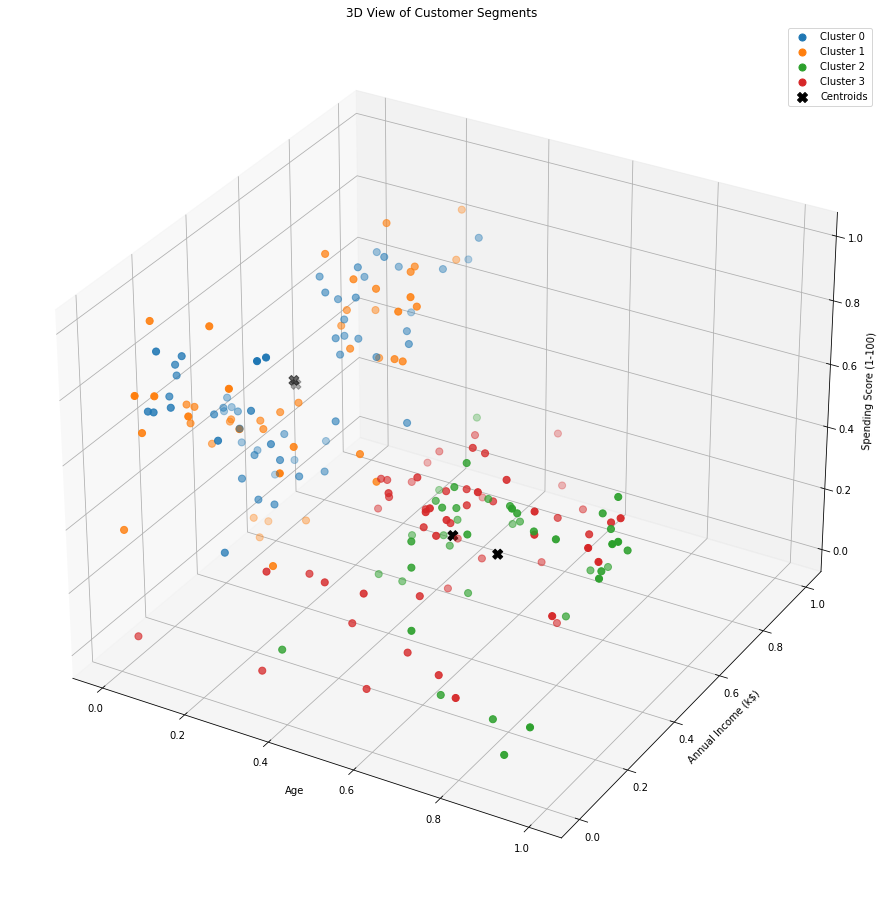

In [32]:

# Extract the features for 3D plotting: Age, Annual Income, and Spending Score
X_plot = df_scaled[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].to_numpy()

# Create a 3D plot
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for i in range(k):
    ax.scatter(X_plot[cluster_labels == i, 0], X_plot[cluster_labels == i, 1], X_plot[cluster_labels == i, 2],
               label=f'Cluster {i}', s=50)

# Plot centroids
ax.scatter(final_centroids[:, 1], final_centroids[:, 2], final_centroids[:, 3], color='black',
           label='Centroids', s=100, marker='X')

# Labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D View of Customer Segments')
ax.legend()

plt.show()


In [33]:
# Save the DataFrame with cluster labels to a CSV file
output_file_path = 'pizza_customers_with_cluster_details.csv'
# Uncomment the below line in case  pizza customers file is stored in google drive
# output_file_path='/content/drive/MyDrive/pizza_customers_with_cluster_details.csv'
df.to_csv(output_file_path, index=False)
output_file_path


'pizza_customers_with_cluster_details.csv'

### Applying Appropriate Labels to Clusters
To label the clusters appropriately, we'll first take a closer look at the characteristics of the data points belonging to each cluster.  we will first examine the mean values of each feature within each cluster.

In [34]:
# Calculate the mean of each feature for each cluster
cluster_means = df.groupby('Cluster').mean()
cluster_means


,Gender,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,
0,0.0,28.438596,59.666667,67.684211
1,1.0,28.000000,62.239130,64.826087
2,1.0,52.738095,62.214286,30.642857
3,0.0,48.109091,58.818182,34.781818


### After examining the mean values of each feature for each cluster, we can make the following observations:
<fieldset><legend>Cluster 0</legend>
    <p>
     Gender: Predominantly Female
     </p><p>
    Age: Younger (around 28 years)
    </p><p>
    Annual Income: Moderate (around $59,000)
    </p><p>
    Spending Score: High (around 68)
    </p>
</fieldset>
<fieldset><legend>Cluster 1</legend>
    <p>
     Gender: Predominantly Male
     </p><p>
    Age: Younger (around 28 years)
    </p><p>
    Annual Income: Moderate (around $62,000)
    </p><p>
    Spending Score: High (around 63)
    </p>
</fieldset>

<fieldset><legend>Cluster 2</legend>
    <p>
     Gender: Predominantly Male
     </p><p>
    Age: Older (around 53 years)
    </p><p>
    Annual Income: Moderate (around $62,000)
    </p><p>
    Spending Score: Low (around 31)
    </p>
</fieldset>

<fieldset><legend>Cluster 3</legend>
    <p>
     Gender: Predominantly Female
     </p><p>
    Age: Older (around 48 years)
    </p><p>
    Annual Income: Moderate (around $59,000)
    </p><p>
    Spending Score: High (around 35)
    </p>
</fieldset>

<fieldset><legend>Cluster Labels</legend>
<p>Based on the above observations, the clusters can be labeled as below :</p>
<ol>
<li>Cluster 0: "Younger Females, High Spending, Moderate income"</li>
<li>Cluster 1: "Younger Males, High Spending less then Females, Moderate Income but more then femals"</li>
<li>Cluster 2: "Older Males, Little Spending, Moderate income as par with cluster 1"</li>
<li>Cluster 3: "Older Females,Little spending but slightly higher then older Males, Moderate income"</li>
</ol>
</fieldset>



In [35]:
# Add appropriate labels to the clusters
cluster_labels_dict = {
    0: "Younger Females, High Spending , Moderate Income",
    1: "Younger Males, Higher Spending , Moderate (Slightly higher) Income",
    2: "Older Males, Little Spending , Moderate Income",
    3: "Older Females, Little Spending , Moderate Income"
}
df['Cluster Label'] = df['Cluster'].map(cluster_labels_dict)
# Show sample dataset with cluster labels
df.sample(10)

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster,Cluster Label
183,0,29,98,88,0,"Younger Females, High Spending , Moderate Income"
8,1,64,19,3,2,"Older Males, Little Spending , Moderate Income"
10,1,67,19,14,2,"Older Males, Little Spending , Moderate Income"
123,1,39,69,91,1,"Younger Males, Higher Spending , Moderate (Sli..."
120,1,27,67,56,1,"Younger Males, Higher Spending , Moderate (Sli..."
105,0,21,62,42,0,"Younger Females, High Spending , Moderate Income"
29,0,23,29,87,0,"Younger Females, High Spending , Moderate Income"
148,0,34,78,22,3,"Older Females, Little Spending , Moderate Income"
109,1,66,63,48,2,"Older Males, Little Spending , Moderate Income"
59,1,53,46,46,2,"Older Males, Little Spending , Moderate Income"


<fieldset>
<legend> Marketing Offers</legend>
Based on the customer segments, below are some proposed marketing offers:

<b>Younger Females, Higher Spending</b>
Offers: Limited-time promotions on new or exotic pizza flavors, possibly combined with a loyalty program to encourage repeat visits. Also offers on restaurants at exotic places
Logic: This group is younger and willing to spend more and ready to explore different flavours and places. They might be more open to trying new things and could become repeat customers if incentivized properly.

<b>Younger Males, Higher Spending</b>
Offers: Limited-time promotions on new or exotic pizza flavors, possibly combined with a loyalty program to encourage repeat visits. Also offers on restaurants at exotic places
Logic: This group is younger and willing to spend more and ready to explore different flavours and places. They might be more open to trying new things and could become repeat customers if incentivized properly.

<b>Older Males, Low Spending</b>
Offers: Discounts on family-size pizzas or combo deals that include appetizers and drinks.Special weekday offers or happy hour discounts to boost sales during low-traffic hours.
Logic: This group is older and has a lower spending score, suggesting they might be more value-conscious and would appreciate bundled offers. This group might  appreciate a good deal, especially during off-peak hours

<b>Older Females, Low Spending</b>
Offers: Discounts on family-size pizzas or combo deals that include appetizers and drinks ,special weekday offers or happy hour discounts to boost sales during low-traffic hours.
Logic: his group is older and has a lower spending score, suggesting they might be more value-conscious and would appreciate bundled offers. This group might  appreciate a good deal, especially during off-peak hours

</fieldset>

### Kafka Data Producer , to Simulate Customer Location Data
<p>
The code will look at each customer and will send the data to Kafka Server also will visualtize in 20 * 20 Matrix
</p>

In [44]:
# Initialize Kafka producer
# Define mall dimensions (rows x columns)
rows, cols = 20, 20
# Initialize mall as 2D grid
mall = [['-' for _ in range(cols)] for _ in range(rows)]
def print_mall(mall):
    """Print the mall grid."""
    for row in mall:
        print(' '.join(row))
    print()
# Simulate customer movements
def simulate_movements(mall, customer_positions, steps=10):
    """Simulate customer movements for a given number of steps."""
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
    
    for step in range(steps):
        print(f"Step {step+1}")
        
        # Move each customer
        for customer_id, (row, col) in customer_positions.items():
            mall[row][col] = '-'  # Empty the current position
            
            # Randomly choose a direction
            d_row, d_col = random.choice(directions)
            
            # Update the new position
            new_row, new_col = row + d_row, col + d_col
            
            # Boundary conditions
            new_row = min(max(new_row, 0), rows - 1)
            new_col = min(max(new_col, 0), cols - 1)
            
            # Move customer to the new position
            mall[new_row][new_col] = str(customer_id)
            customer_positions[customer_id] = (new_row, new_col)
        
        # Print the mall layout and simulate real-time by pausing
        print_mall(mall)
        time.sleep(1)
            
producer = KafkaProducer(
    bootstrap_servers='localhost:9092', 
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)
# Simulate sending customer location data
customer_positions = {}
for customer_id in df.index:
    location = {
        'x': random.randint(0, rows-1),  # x-coordinate
        'y': random.randint(0, cols-1)   # y-coordinate
    }
    message = {
        'customer_id': customer_id,
        'location': location,
        'timestamp': time.time()
    }
    mall[location['x']][location['y']] = str(customer_id)
    customer_positions[customer_id] = (location['x'], location['y'])
    # Run the simulation for 4 steps to demonstrate
    # below code can be changed to run based on tiem as well
    simulate_movements(mall, customer_positions, steps=1)
    # Send message to Kafka topic named 'customer_locations'
    producer.send('customer_locations', message)
    # Simulate real-time data by sleeping for a short while
    time.sleep(1)

Step 1
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - 0 - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -

Step 1
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - -

KeyboardInterrupt: 

### Simulate Customer Movement in a mall by generating dummy data for customer location for visual purpose , Code above will generate the Dummy location and send it to server as well, here it will s=just display for demo purposes

In [43]:

# Define mall dimensions (rows x columns)
rows, cols = 20, 20

# Initialize mall as 2D grid
mall = [['-' for _ in range(cols)] for _ in range(rows)]

# Randomly place customers in the mall
customer_positions = {}
for customer_id in df.index:
    row, col = random.randint(0, rows-1), random.randint(0, cols-1)
    mall[row][col] = str(customer_id)
    customer_positions[customer_id] = (row, col)

def print_mall(mall):
    """Print the mall grid."""
    for row in mall:
        print(' '.join(row))
    print()

# Simulate customer movements
def simulate_movements(mall, customer_positions, steps=10):
    """Simulate customer movements for a given number of steps."""
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
    
    for step in range(steps):
        print(f"Step {step+1}")
        
        # Move each customer
        for customer_id, (row, col) in customer_positions.items():
            mall[row][col] = '-'  # Empty the current position
            
            # Randomly choose a direction
            d_row, d_col = random.choice(directions)
            
            # Update the new position
            new_row, new_col = row + d_row, col + d_col
            
            # Boundary conditions
            new_row = min(max(new_row, 0), rows - 1)
            new_col = min(max(new_col, 0), cols - 1)
            
            # Move customer to the new position
            mall[new_row][new_col] = str(customer_id)
            customer_positions[customer_id] = (new_row, new_col)
        
        # Print the mall layout and simulate real-time by pausing
        print_mall(mall)
        time.sleep(1)

# Run the simulation for 4 steps to demonstrate
# below code can be changed to run based on tiem as well
simulate_movements(mall, customer_positions, steps=4)


Step 1
- - - - - - - - - 47 151 - - - 126 - - - 59 -
- 134 - - - - - 110 122 - 174 - - - 129 - - - - -
- - - 180 - 21 - - 33 195 - - 199 155 - - - - - 158
139 - - 133 - - - 132 - 71 - - - - 128 - 115 173 - -
- 95 - - - - 31 - - - 197 - - - - 190 - - 113 -
- - 109 - 125 - - - - 114 - 157 166 - - 77 179 - 178 -
- 171 - - - - - 127 - 142 - - - 123 163 - 187 - - -
- - - - 58 - - - - - 0 - - - - - 193 - - 141
- 76 148 181 - - - - - - - - 118 - - - - - 167 -
- - 170 - - - - - - 103 175 61 82 145 - 192 124 - - -
- - - - - - - - 2 86 - - - 101 131 - - 161 - -
- 154 - - - - 168 85 - - - - 64 - - - - 188 - -
- - 14 - - - - 117 - 159 - - 164 - - 189 - - - -
147 186 - - 120 - - - 137 - 84 177 - - - - - - - 172
- - 13 - 5 - - - 80 - 43 66 - - 34 153 - - 55 28
- - - - 25 - 26 - - - 81 - 51 - - 89 183 - - -
- 29 146 - 88 - - - - - - - 60 97 - 184 - 169 87 -
- 149 - 162 198 - - 111 - 176 - - 24 - - - - - - 73
69 - - - - 136 - 150 152 - - - 56 108 119 - 196 - 121 -
- 99 - 191 - - 194 19 - - 4 - - - - -

### Kafka Consumer To send the offers to customer based on their clusters

In [ ]:
df_with_Cluster=pd.read_csv('pizza_customers_with_cluster_details.csv')

# Initialize Kafka Consumer
consumer = KafkaConsumer(
    'customer_locations',  # Topic name
    bootstrap_servers='localhost:9092',  # Replace with the address of your Kafka server
    value_deserializer=lambda m: json.loads(m.decode('utf-8'))
)
def get_cluster_name_from_customer_id(customer_id, df):
    try:
        cluster_name = df_with_Cluster.loc[df['CustomerID'] == customer_id, 'Cluster'].iloc[0]
        return cluster_name
    except IndexError:
        return "Customer ID not found"



# Business Logic to decide the offer
def decide_offer(customer_id, location):
    # Simulate decision logic here
    # For demonstration, we are sending the same offer to all customers
    if get_cluster_name_from_customer_id(customer_id)=="0" :
        return "50% off on your next purchase!"
    elif get_cluster_name_from_customer_id(customer_id)=="1" :
        return "50% off on your next purchase!"
    elif get_cluster_name_from_customer_id(customer_id)=="2" :
        return "50% off on your next purchase!"
    elif get_cluster_name_from_customer_id(customer_id)=="3" :
        return "50% off on your next purchase!"
    
# Consume messages from Kafka topic
for message in consumer:
    customer_data = message.value
    customer_id = customer_data['customer_id']
    location = customer_data['location']
    
    print(f"Received location data for Customer {customer_id}: {location}")
    
    # Store this data if needed (e.g., in a database)
    # Code to store data here
    
    # Decide which offer to trigger based on customer_id and/or location
    offer = decide_offer(customer_id, location)
    
    # Send this offer to the customer's mobile device
    # Code to send offer here
    print(f"Sent offer to Customer {customer_id}: {offer}")
    
    # Simulate real-time offer placing by sleeping for a short while
    time.sleep(1)
